這邊利用課本中的範例4.3來說明value iteration的過程，程式碼主要參考的是[ShangtongZhang](https://github.com/ShangtongZhang/reinforcement-learning-an-introduction/blob/master/chapter04/gamblers_problem.py)，再加上自己理解的註解。

這範例說明的是一個賭徒去猜一系列的拋硬幣的結果。如果硬幣朝上，那賭徒就得到跟他這次下注一樣多的錢；如果硬幣朝下，那就輸了這次下注的錢。當賭徒贏100元或是輸到脫褲那就結束。每次拋硬幣，賭徒都需要決定要下注多少，而且是整數。這可以描述成一個undiscounted、episodeic、finite MDP的問題：
* state：賭徒的資金，也就是已經贏多少了，$s\in \left\{1,2,3,...,99 \right\}$
* action：下注的金額，$a\in\left\{0,1,...,\min(s, 100-s) \right\}$
* reward：達到目標(贏100元)的時候+1，其它狀態轉移的時候皆為0

state-value function會給出每一個state賭徒會贏的機率。這邊的policy是賭徒資金到下注的映射。optimal policy會最大化達到目標的機率。

假設，$p_h$表示硬幣會是正面的機率。如果$p_h$已知，那整個問題就可以求解了，像是用value iteration來求解。Figure 4.3說明了value iteration連續掃描過程中的value function的變化，以及找到最終的policy($p_h=0.4$)。policy是最佳的(optimal)，但並非是唯一的。事實上optimal policies有一堆，具體取決於能夠最大化value function的那個action的選擇(argmax action)。

$$
\begin{align}
v_{k+1}(s) & \dot{=} \max_a \mathbb{E}[R_{t+1} + \gamma v_k(S_{t+1})\vert S_{t}=s, A_{t}=a] \\
&=\max_a\sum_{s',r}p(s', r\vert s, a)[r + \gamma v_k(s')]
\end{align} \tag{4.10}
$$ 

載入需求套件

In [9]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline 

下面根據狀況說明設置參數

賭徒只要贏到100元那就是贏，reward + 1

In [10]:
GOAL = 100

設置state spaces，因為只要贏到100那就是贏，所以state會是0~100

In [11]:
STATES = np.arange(GOAL + 1)
STATES

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100])

出現正面的機率，根據說明，這個機率會是0.4

In [12]:
HEAD_PROB = 0.4

下面我們設置函數開始這個value iteration

In [15]:
def figure_4_3():
    # state value
    # 只有在到達目標，也就是贏到100元的時候才是1，其餘都會是0
    state_value = np.zeros(GOAL + 1)
    state_value[GOAL] = 1.0
    
    sweeps_history = []
    # value iteration
    while True:        
        # 跟之前的範例一樣的作法
        old_state_value = state_value.copy()
        # 記錄value function的變化
        sweeps_history.append(old_state_value)
        
        # 列出所有可能的state
        for state in STATES[1:GOAL]:
            # 根據文中說明設置每個state所擁有的actions
            # 取小是因為，你如果身上只有30元，那當然就只能下注30，
            # 如果你身上有70元，目標100，那你就只需要再下注30就能達到目標
            actions = np.arange(min(state, GOAL - state) + 1)
            # 記錄每一個action會有的return
            action_returns = []
            for action in actions:
                # 計算每一個action的return
                # 正面的機率0.4 * 該state + 下注後的金額的的value(贏) + 
                # 反面的機率0.6 * 該state - 下注後的金額的value(輸)
                action_returns.append(
                    HEAD_PROB * state_value[state + action] + (1 - HEAD_PROB) * state_value[state - action]
                )
            # 根據4.10，我們直接取最大的那一個值做為該state的value
            new_value = np.max(action_returns)
            state_value[state] = new_value
        # 計算新、舊value function之間的差異，判斷是否小於閥值
        delta = abs(state_value - old_state_value).max()
        if delta < 1e-9:
            sweeps_history.append(state_value)
            break            
    
    # value function好了之後就要計算optimal oplicy
    policy = np.zeros(GOAL + 1)
    for state in STATES[1: GOAL]:
        actions = np.arange(min(state, GOAL - state) + 1)        
        action_returns = []
        for action in actions:
            action_returns.append(
                HEAD_PROB * state_value[state + action] + (1 - HEAD_PROB) * state_value[state - action]
            )          
        # round to resemble the figure in the book, see
        # https://github.com/ShangtongZhang/reinforcement-learning-an-introduction/issues/83
        # 大致就是四捨五入之後取最大的一個來做為遇到這個state預計執行的action
#         print(action_returns)
        policy[state] = actions[np.argmax(np.round(action_returns[1: ], 5)) + 1]        
        
    # 下面開始設置圖表
    plt.figure(figsize=(10, 20))
    # 設置子圖表
    plt.subplot(2, 1, 1)
    for sweep, state_value in enumerate(sweeps_history):
        plt.plot(state_value, label=f'sweep {sweep}')
    
    plt.xlabel('Capital')
    plt.ylabel('Value estimates')
    plt.legend(loc='best')
    
    # 設置另一個子圖
    plt.subplot(2, 1, 2)
    plt.scatter(STATES, policy)
    plt.xlabel('Capital')
    plt.ylabel('Final policy (stake)')
    
    plt.show()
    plt.close()

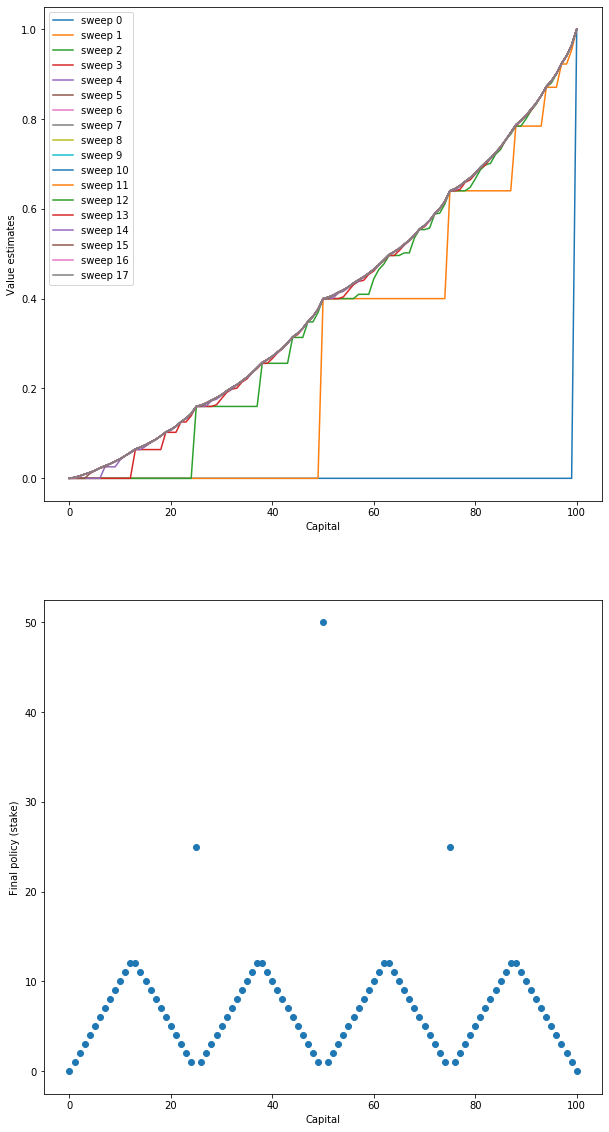

In [16]:
figure_4_3()